In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import shutil
from pathlib import Path

import cv2

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow_probability import distributions as tfd

from tensorflow.train import BytesList
from tensorflow.train import Example, Features, Feature

from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.neighbors import NearestNeighbors

print(f"Tensorflow {tf.__version__}")
tf.config.list_physical_devices()

Tensorflow 2.4.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Image Colorization Model "Ipix" - DATA PREPARING
## Author: Tsvetoslav Nikolov
### Image colorization model implemented in Ipix

# Abstract
To Do

# Introduction
Image colorization is a big part of computer vision. Nowadays there are a few researches which seem to be very encouraging. This paper will show you in detail some of their aspects and how we can combine them to train a new model. Also, this model will be a big part of my project for the NOIT2020.

We are going to try different architectures(as many as we can) and optimize them so in the end we shoud be able to completely colorize a greyscale image(perhaps with the user's help).

## Data Preprocessing (Image Datasets Resizing)

In [3]:
def get_padded_name(num, places = 4, prefix = ""):
    num = str(num)
    name = ((places - len(num)) * "0") + num + ".jpg";
    return prefix + name

def resize_dataset(base_dir, target_dir, size = (256, 256), preserve_filenames = False):
    imgs_count = str(len(list(base_dir.glob('**/*.*'))))
    if not target_dir.exists():
        os.mkdir(str(target_dir))
    
    for i, filepath in enumerate(Path(base_dir).glob("**/*.*")):
        if i % 10 == 0:
            print(f"{i}/{imgs_count}")
        img = cv2.imread(str(filepath.absolute()))
        img_resized = cv2.resize(img, size)
        if not preserve_filenames:
            path = str(target_dir / get_padded_name(i, places = len(imgs_count)))
        else:
            path = str(target_dir / filepath.stem) + ".jpg"
        cv2.imwrite(path, img_resized)
        

In [4]:
LANDSCAPES_BASEDIR = Path(os.getcwd()).parent  / "Data" / "Landscapes"
LANDSCAPES_TARGETDIR = Path(os.getcwd()).parent  / "Data" / "LandscapesResized"
# resize_dataset(LANDSCAPES_BASEDIR, LANDSCAPES_TARGETDIR)

In [5]:
FFHQ_BASEDIR = Path(os.getcwd()).parent  / "Data" / "FFHQ"
FFHQ_TARGETDIR = Path(os.getcwd()).parent  / "Data" / "FFHQResized"
# resize_dataset(FFHQ_BASEDIR, FFHQ_TARGETDIR)

In [6]:
FLICKR8K_BASEDIR = Path(os.getcwd()).parent  / "Data" / "Flicker8k_Dataset"
FLICKR8K_TARGETDIR = Path(os.getcwd()).parent  / "Data" / "Flicker8kResized"
# resize_dataset(FLICKR8K_BASEDIR, FLICKR8K_TARGETDIR, preserve_filenames = True)

We will split landscapes and flick8k into train, val and test sets and add them to places. Since the datasets are already shuffled and named properly(by id) we can just compute how many we need for training, testing and validating and take them. 

In [7]:
landscapes_count = len(list(LANDSCAPES_TARGETDIR.glob('**/*.*')))
ffhq_count = len(list(FFHQ_TARGETDIR.glob('**/*.*')))

In [8]:
landscapes_split = (0.6, 0.15, 0.25)
ffhq_split = (0.6, 0.1, 0.3)

def get_split(split, count, dataset_name):
    print(dataset_name)
    train_images_count = int(split[0] * count)
    val_images_count = int(split[1] * count)
    test_images_count = int(split[2] * count)
    
    print(f"{train_images_count} train images ({split[0] * 100}%)")
    print(f"{val_images_count} val images ({split[1] * 100}%)")
    print(f"{test_images_count} test images ({split[2] * 100}%)")
    print(20 * "-")
    
    return train_images_count, val_images_count, test_images_count
    
landscapes_split = get_split(landscapes_split, landscapes_count, "Landscapes")
ffhq_split = get_split(ffhq_split, ffhq_count, "FFHQ")

Landscapes
2591 train images (60.0%)
647 val images (15.0%)
1079 test images (25.0%)
--------------------
FFHQ
943 train images (60.0%)
157 val images (10.0%)
471 test images (30.0%)
--------------------


In [9]:
def copy_and_split_files(dataset_dir, dataset_split, dataset_name):
    for i, filepath in enumerate(Path(dataset_dir).glob("**/*.*")):
        if i % 10 == 0:
            print(f"{i}/{dataset_split[0] + dataset_split[1] + dataset_split[2]}")
        
        if i <  dataset_split[0]:
            shutil.copyfile(str(filepath.absolute()), str(Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "data_256" / dataset_name / filepath.name))
            
        elif i < dataset_split[0] + dataset_split[1]:
            shutil.copyfile(str(filepath.absolute()), str(Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "val_256" / filepath.name))
        else:
            shutil.copyfile(str(filepath.absolute()), str(Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "test_256" / filepath.name))
        
# copy_and_split_files(LANDSCAPES_TARGETDIR, landscapes_split, "kaggle_landscapes")
# copy_and_split_files(FFHQ_TARGETDIR, ffhq_split, "ffhq")

In [10]:
FLICKR8K_TRAIN_NAMES = Path(os.getcwd()).parent  / "Data" / "Flickr8k_text" / "Flickr_8k.trainImages.txt"
FLICKR8K_VAL_NAMES = Path(os.getcwd()).parent  / "Data" / "Flickr8k_text" / "Flickr_8k.devImages.txt"
FLICKR8K_TEST_NAMES = Path(os.getcwd()).parent  / "Data" / "Flickr8k_text" / "Flickr_8k.testImages.txt"

train_names = open(FLICKR8K_TRAIN_NAMES, "r").readlines()
val_names = open(FLICKR8K_VAL_NAMES, "r").readlines()
test_names = open(FLICKR8K_TEST_NAMES, "r").readlines()

FLICKR8K_train_data_count = len(train_names)
FLICKR8K_val_data_count = len(val_names)
FLICKR8K_test_data_count = len(test_names)

FLICKR8K_total_data_count = FLICKR8K_train_data_count + FLICKR8K_val_data_count + FLICKR8K_test_data_count

print("Flickr8k Split")
print(f"{FLICKR8K_train_data_count} train images ({FLICKR8K_train_data_count * 100 / FLICKR8K_total_data_count}%)")
print(f"{len(val_names)} val images ({FLICKR8K_val_data_count * 100 / FLICKR8K_total_data_count}%)")
print(f"{len(test_names)} test images ({FLICKR8K_test_data_count * 100 / FLICKR8K_total_data_count}%)")

def copy_files_to_dir(files, base_dir, target_dir, prefix = ""):
    files_count = len(files)
    for i, name in enumerate(files):
        if i % 10 == 0:
            print(f"{i/files_count}")
        image_path =  base_dir / name.strip()
        if prefix == "":
            shutil.copyfile(str(image_path), str( target_dir / get_padded_name(i, len(str(files_count)))))
        else:
            shutil.copyfile(str(image_path), str( target_dir / get_padded_name(i, len(str(files_count)), prefix = prefix)))
            
# print("Train data copying")
# copy_files_to_dir(train_names, FLICKR8K_TARGETDIR, Path(os.getcwd()).parent / "Data" / "DatasetsMix" / "256" / "data_256" / "flickr8k")

# print("Val data copying")
# copy_files_to_dir(val_names, FLICKR8K_TARGETDIR, Path(os.getcwd()).parent / "Data" / "DatasetsMix" / "256" / "val_256", prefix = "flickr8.")

# print("Train data copying")
# copy_files_to_dir(test_names, FLICKR8K_TARGETDIR, Path(os.getcwd()).parent / "Data" / "DatasetsMix" / "256" / "test_256", prefix = "flickr8.")

Flickr8k Split
6000 train images (75.0%)
1000 val images (12.5%)
1000 test images (12.5%)


In [11]:
import math as m
pi = tf.constant(m.pi)

img = tf.io.read_file(r"F:\Ipix\Data\DatasetsMix\256\data_256\ffhq\0002.jpg")
img = tf.image.decode_jpeg(img)
img = tf.image.convert_image_dtype(img, tf.float32)
img_rotated = tfa.image.rotate(img, pi/4)

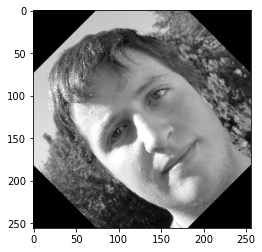

In [12]:
img_lab = tfio.experimental.color.rgb_to_lab(img)
img_l = img_lab[:, :, 0]
img_l_rotated = tfa.image.rotate(img_l, pi/4)
plt.imshow(img_l_rotated, cmap="gray")
plt.show()

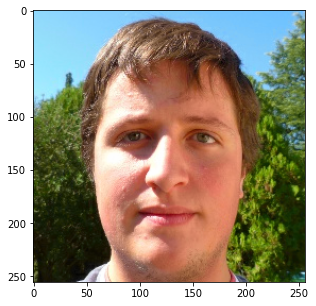

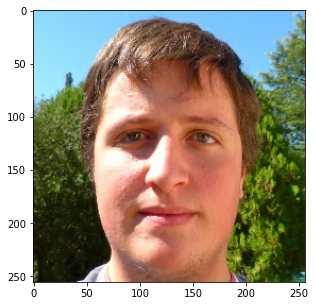

In [13]:
color_space = np.load("./assets/pts_in_hull.npy")
kn = NearestNeighbors(n_neighbors=5, algorithm="ball_tree").fit(color_space)

def soft_encode(image_lab, knn, sigma = 5., color_space_bins = 313):
    """Compute The Soft-Encoded Vector."""
    
    L = image_lab[:, :, 0]
    ab = tf.reshape(image_lab[:, :, 1:], [-1, 2])
    dist, ids = kn.kneighbors(ab)
    
    smoothed_dist = np.exp(-dist ** 2 / (2 * sigma ** 2))
    smoothed_dist = smoothed_dist / np.sum(smoothed_dist, axis=1)[:, np.newaxis]
    
    smoothed_ab_encoding = np.zeros((ab.shape[0], color_space_bins))
    smoothed_ab_encoding[np.arange(ab.shape[0])[:, np.newaxis], ids] = smoothed_dist

    smoothed_ab_encoding = tf.convert_to_tensor(smoothed_ab_encoding, tf.float32)
    return smoothed_ab_encoding, L


def dist_to_point_est(softmax_result, out_shape=(256, 256)):
    """Compute Points Estimation"""
    
    annealed_mean_dist = tf.math.exp(tf.math.log(softmax_result + 1e-8) / 0.5)
    annealed_mean_dist = annealed_mean_dist / tf.expand_dims(tf.math.reduce_sum(annealed_mean_dist, 1), 1)    
    
    q_a = tf.convert_to_tensor(color_space[:, 0].reshape((1, 313)), tf.float32)
    q_b = tf.convert_to_tensor(color_space[:, 1].reshape((1, 313)), tf.float32)
        
    a = annealed_mean_dist * q_a
    b = annealed_mean_dist * q_b
    
    a = tf.math.reduce_sum(a, 1)
    b = tf.math.reduce_sum(b, 1)
    
    a = tf.reshape(a, out_shape)
    b = tf.reshape(b, out_shape)
    
    return a, b

def test_encoding_and_decoding(img):
    a_b_soft_encoded, L = soft_encode(img, kn)
    a, b = dist_to_point_est(a_b_soft_encoded)
    
    reconstructed_lab = tf.stack([L, a, b], -1)

    reconstructed_rgb = tfio.experimental.color.lab_to_rgb(reconstructed_lab)
    real_rgb = tfio.experimental.color.lab_to_rgb(img)

    plt.figure(figsize=(5, 5))
    plt.imshow(reconstructed_rgb)
    plt.show()
    plt.figure(figsize=(5, 5))

    plt.imshow(real_rgb)
    plt.show()
        
test_encoding_and_decoding(img_lab)

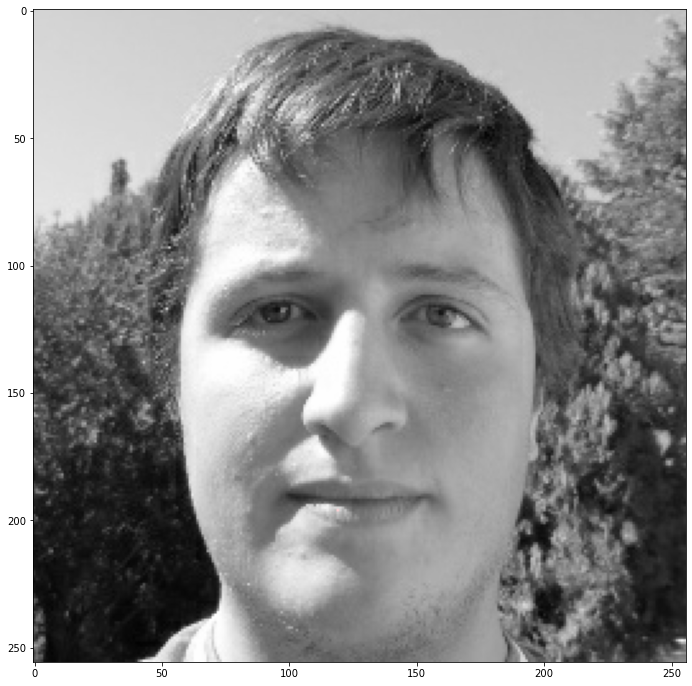

In [14]:
H = 256
W = 256

GD = tfd.Sample(tfd.Geometric(probs=1/8))
MVN = tfd.Sample(tfd.MultivariateNormalDiag(loc = [H/2, W/2], scale_diag = [H/4, W/4]))

def generate_user_points(image_l, image_rgb):
    image_added_points = tf.image.grayscale_to_rgb(tf.expand_dims(image_l, axis=-1)) / 100

    
    points_count = GD.sample()
    points_xy = MVN.sample(points_count)
    points_xy = tf.cast(points_xy, tf.int32)
    if points_xy.shape[0] != 0:
        points_values = tf.gather_nd(image_rgb, points_xy)
        image_added_points = tf.tensor_scatter_nd_update(
            image_added_points, points_xy, points_values
        )
    
    return image_added_points


image_with_added_points = generate_user_points(img_lab[:, :, 0], img)
plt.figure(figsize = (12, 12))
plt.imshow(image_with_added_points)

In [15]:
def get_global_statistics(image_lab, image_rgb, resize_smaller = 4):
    user_defined = tf.constant(1, image_lab.dtype, shape = 1)
    H = image_lab.shape[0]
    W = image_lab.shape[1]
    
    image_resized = tf.image.resize(image_lab, [int(H/resize_smaller), int(W/resize_smaller)])
    quantized_encoding, _ = soft_encode(image_resized, kn)
    
    quantized_encoding_mean = tf.reduce_mean(quantized_encoding, axis = 0)
    
    #Compute std for R, G and B
    RMSContrast = tf.math.reduce_std(tf.reshape(image_rgb, [-1, 3]), axis=0)
    
    # Concatenate
    global_stats_vector = tf.concat([quantized_encoding_mean, RMSContrast, user_defined], axis=0)
    
    # Create input tensor with shape (1, 1, -1)
    global_stats_vector_input_tensor = tf.reshape(global_stats_vector, [1, 1, -1])
    
    return global_stats_vector_input_tensor

def get_empty_global_statistics():
    return tf.zeros((1, 1, 317))

# Speed up process(or just try...We have to try, because the hope is....)
Two options came to my ming when I started thinking of this. The first(and for me personaly the best) way is to preprocess the data so that the CPU will have to run easier computations(tasks like load the data, augment it and pass it to the GPU). The best way to do that is to use tensorflow TFrecord file format which stores binary information. I will write the code just for the experiment, but keep in mind that when we work mainly with images, the memory taken by the information MATTERS(especially when we have a big big BIG dataset). A rought computation showed me that I will 1.9 + TB memory to store all of the informaiton(all of the sklearn soft encoding, global statistics, and the input for VGG). Actually I think there is no problem to use tf.data with mapping to function which will compute the soft encoding(like the one showed in the previuos section), but sklearn uses the CPU and if we DO NOT have the best CPU in the world, it can drasticaly slow down the process of training. Most of the works online uses map to compute everything each time the image is loaded(well, there is smarter way with tensorflow for some kind of optimizations(like cach, etc.)). Because I have the memory to save the preproccessed data, I will try to save it as TFrecords and I will explain why I love them and I hate them at the same time later. Then, I will try to get the best out of my computer and if I am not pleased with the result(the time for each epoch or for each samples or if there is a gap between the GPU and the CPU) I will try to make it with mapping and train it on the cloud. When we train on the cloud every GB of memory costs! And it COSTS especially when we have to buy aroung 2 TB of memory :D So if I choose the variant with the cloud, I will save the "raw"(It is already resized 256, 256) dataset wich is around 30GB and preprocess every image with the CPU and Dataset.map :D 

For there is no better way to understand and gain experience than to try it on your own(when you have the time and the resources:D).

And also when it comes to ML and DL, what I learned is that when you have to choose between two or more smart variants the best way is to try them all(or if you dont have the time to do that to search, but it is not the same).

In [16]:
training_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "data_256"
val_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "val_256"
test_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "test_256"

# train_ds = tf.data.Dataset.list_files(str(training_data_dir / '*/*'), shuffle=True, seed=1234)
# val_ds = tf.data.Dataset.list_files(str(val_data_dir / '*'), shuffle=False)
# test_ds = tf.data.Dataset.list_files(str(test_data_dir / '*'), shuffle=False)

In [17]:
# train_len = tf.data.experimental.cardinality(train_ds).numpy()
# val_len = tf.data.experimental.cardinality(val_ds).numpy()
# test_len = tf.data.experimental.cardinality(test_ds).numpy()

# print(f"{train_len} train images")
# print(f"{test_len} test images")
# print(f"{val_len} val images")

In [18]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.numpy()]))

class DatasetGenerator():
    
    def __init__(self, ab_bins_path = "./assets/pts_in_hull.npy", image_default_shape = (256, 256)):
        
        self.color_space = np.load(ab_bins_path)
        self.knn = NearestNeighbors(n_neighbors=6, algorithm="ball_tree", n_jobs = -1).fit(self.color_space)
        self.image_default_shape = image_default_shape
        self.image_gamut_shape = [int(image_default_shape[0] / 2),
                                  int(image_default_shape[1] / 2)]
        
    def load_image(self, image_path):
        self.img_rgb_raw_bytes = tf.io.read_file(image_path)
        self.img_rgb_raw = tf.image.decode_jpeg(self.img_rgb_raw_bytes, channels = 3)
        
        # Convert and NORMALIZE image [0, 1]
        self.img_rgb = tf.cast(self.img_rgb_raw, tf.float32) / 255.
        
        # Convert to Lab
        self.img_lab = tfio.experimental.color.rgb_to_lab(self.img_rgb)
        
        self.dist, self.ids, self.ab = self.compute_neighbors()
        
        # Compute pixels AB distribution
        self.gamut_dist = self.get_soft_encoding_reduced()
        
        # Compute global stats
        self.global_stats = self.get_global_statistics()
    
    def compute_neighbors(self):
        lab_resized = tf.image.resize(self.img_lab, self.image_gamut_shape)
        ab = tf.reshape(lab_resized[:, :, 1:], [-1, 2])
        dist, ids = self.knn.kneighbors(ab)
        return dist, ids, ab
    
    def get_soft_encoding(self, sigma = 5.):
        """Compute The Soft-Encoded Vector."""
#         lab_resized = tf.image.resize(self.img_lab, self.image_gamut_shape)
#         ab = tf.reshape(lab_resized[:, :, 1:], [-1, 2])
#         dist, ids = self.knn.kneighbors(ab)
        
        smoothed_dist = np.exp(-self.dist ** 2 / (2 * sigma ** 2))
        smoothed_dist = smoothed_dist / np.sum(smoothed_dist, axis=1)[:, np.newaxis]

        smoothed_ab_encoding = np.zeros((self.ab.shape[0], self.color_space.shape[0]))
        smoothed_ab_encoding[np.arange(self.ab.shape[0])[:, np.newaxis], self.ids] = smoothed_dist

        smoothed_ab_encoding = tf.convert_to_tensor(smoothed_ab_encoding, tf.float32)
        smoothed_ab_encoding = tf.reshape(smoothed_ab_encoding, [*self.image_gamut_shape, -1])
        
        return smoothed_ab_encoding
    
    
    def get_soft_encoding_reduced(self, sigma = 5.):
        """Compute The Soft-Encoded Vector, but as tensor where every pixel has (5, 2) 
        values (indeces, smoothed probabilties) in order to reduce the size of the result"""
        
#         lab_resized = tf.image.resize(self.img_lab, self.image_gamut_shape)
#         ab = tf.reshape(lab_resized[:, :, 1:], [-1, 2])
#         dist, ids = self.knn.kneighbors(ab)
        
        dist = tf.convert_to_tensor(self.dist, tf.float32)
        ids = tf.convert_to_tensor(self.ids, tf.uint8)

        
        smoothed_dist = tf.math.exp(-dist ** 2 / (2 * sigma ** 2))
        smoothed_dist = smoothed_dist / tf.math.reduce_sum(smoothed_dist, axis=1)[:, tf.newaxis]
        
        smoothed_dist = smoothed_dist * 255
        smoothed_dist = tf.cast(smoothed_dist, tf.uint8)
        
        #Stacking and converting back to tensors at the same time(and casting to float32 because the numpy result is in float64)
        smoothed_ab_encoding = tf.stack([ids, smoothed_dist], axis=-1)
        
        return smoothed_ab_encoding
    
    def get_global_statistics(self, resize_smaller = 4):
        user_defined = tf.constant(1, self.img_lab.dtype, shape = 1)
        gamut = self.get_soft_encoding()
        quantized_encoding_mean = tf.reduce_mean(tf.reshape(gamut, [-1, self.color_space.shape[0]]), axis = 0)

        #Compute std for R, G and B
        RMSContrast = tf.math.reduce_std(tf.reshape(self.img_rgb, [-1, 3]), axis=0) / 255.

        # Concatenate
        global_stats_vector = tf.concat([quantized_encoding_mean, RMSContrast, user_defined], axis=0)

        # Create input tensor with shape (1, 1, -1)
        global_stats_vector_input_tensor = tf.reshape(global_stats_vector, [1, 1, -1])

        return global_stats_vector_input_tensor
    
    
    def serialize_information(self):
        test = self.img_rgb
        test = tf.cast(test * 255, tf.uint8)
        features = Features(feature = {
          'image_rgb': _bytes_feature(self.img_rgb_raw_bytes),
          'gamut_dist': _bytes_feature(tf.io.serialize_tensor(self.gamut_dist)),
          'global_stats': _bytes_feature(tf.io.serialize_tensor(self.global_stats)),
        })

        return Example(features=features).SerializeToString()
        

BASE_DATA_DIR = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "TFRecords_256"

datagen = DatasetGenerator()
tf_record_options = tf.io.TFRecordOptions(compression_type = "GZIP")

def write_as_TFRecords(dataset, target_dir, prefix, batch_size, datagen):
    dataset = dataset.batch(batch_size)
    dataset_len = len(list(dataset))
    for part_id, image_paths in enumerate(dataset):
        print(f"{part_id}/{dataset_len}")
        filename = str(target_dir / f"{prefix}.{part_id}.tfrecord")
        if not Path(filename).is_file():
            with tf.io.TFRecordWriter(filename, options = tf_record_options) as writer:
                for path in image_paths:
                    datagen.load_image(path)
                    writer.write(datagen.serialize_information())
                writer.close()

    
# write_as_TFRecords(dataset = train_ds,
#                    target_dir = BASE_DATA_DIR / "train", 
#                    prefix = "train", 
#                    batch_size = 1024,
#                    datagen = datagen)

# write_as_TFRecords(dataset = val_ds,
#                    target_dir = BASE_DATA_DIR / "val", 
#                    prefix = "val", 
#                    batch_size = len(list(val_ds)),
#                    datagen = datagen)

# write_as_TFRecords(dataset = test_ds,
#                    target_dir = BASE_DATA_DIR / "test", 
#                    prefix = "test", 
#                    batch_size = len(list(test_ds)),
#                    datagen = datagen)

In [30]:
def random_sample(arr, size):
    return arr[np.random.choice(len(arr), size=size, replace=False)]

def clear_sampled_dir(dir_path, suffix = "_sampled"):
    for file_path in Path(dir_path).glob(f"**/*{suffix}.jpg"):
        os.rename(file_path, file_path.parent / file_path.name.replace(suffix, ""))

        
def sample(train_path, factor, suffix = "_sampled"):        
    train_dirs = os.listdir(train_path)

    for i, train_dir in enumerate(train_dirs):
        print(f"Dir {i} of {len(train_dirs)}")
        files = os.listdir(train_path / train_dir)
        files = np.array(files)
        files_count = len(files)
        target_files_count = int(factor * files_count)

        sampled_files = random_sample(files, target_files_count)

        for file in sampled_files:
            file_path = training_data_dir / train_dir / file
            new_file_name = file_path.stem + suffix + ".jpg"
            os.rename(file_path, training_data_dir / train_dir / new_file_name)
            
def clear_sampled(train_path, suffix = "_sampled"):        
    train_dirs = os.listdir(train_path)

    for i, train_dir in enumerate(train_dirs):
        print(f"Dir {i} of {len(train_dirs)}")
        clear_sampled_dir(train_path / train_dir, suffix)

# sample(training_data_dir, factor = 0.35)
# clear_sampled(training_data_dir, suffix = "_smallset")
sample(training_data_dir, factor = 0.18, suffix = "_smallset")
# clear_sampled(training_data_dir, suffix = "_smallset")

Dir 0 of 368
Dir 1 of 368
Dir 2 of 368
Dir 3 of 368
Dir 4 of 368
Dir 5 of 368
Dir 6 of 368
Dir 7 of 368
Dir 8 of 368
Dir 9 of 368
Dir 10 of 368
Dir 11 of 368
Dir 12 of 368
Dir 13 of 368
Dir 14 of 368
Dir 15 of 368
Dir 16 of 368
Dir 17 of 368
Dir 18 of 368
Dir 19 of 368
Dir 20 of 368
Dir 21 of 368
Dir 22 of 368
Dir 23 of 368
Dir 24 of 368
Dir 25 of 368
Dir 26 of 368
Dir 27 of 368
Dir 28 of 368
Dir 29 of 368
Dir 30 of 368
Dir 31 of 368
Dir 32 of 368
Dir 33 of 368
Dir 34 of 368
Dir 35 of 368
Dir 36 of 368
Dir 37 of 368
Dir 38 of 368
Dir 39 of 368
Dir 40 of 368
Dir 41 of 368
Dir 42 of 368
Dir 43 of 368
Dir 44 of 368
Dir 45 of 368
Dir 46 of 368
Dir 47 of 368
Dir 48 of 368
Dir 49 of 368
Dir 50 of 368
Dir 51 of 368
Dir 52 of 368
Dir 53 of 368
Dir 54 of 368
Dir 55 of 368
Dir 56 of 368
Dir 57 of 368
Dir 58 of 368
Dir 59 of 368
Dir 60 of 368
Dir 61 of 368
Dir 62 of 368
Dir 63 of 368
Dir 64 of 368
Dir 65 of 368
Dir 66 of 368
Dir 67 of 368
Dir 68 of 368
Dir 69 of 368
Dir 70 of 368
Dir 71 of 368
Di

In [31]:
# train_ds_sampled = tf.data.Dataset.list_files(str(training_data_dir / '**/*_sampled.jpg'), shuffle=True, seed = 1234)
train_ds_sampled_smallset = tf.data.Dataset.list_files(str(training_data_dir / '**/*_smallset.jpg'), shuffle=True, seed = 1234)

In [32]:
# write_as_TFRecords(dataset = train_ds_sampled,
#                    target_dir = BASE_DATA_DIR / "Train_sampled", 
#                    prefix = "train", 
#                    batch_size = 1024,
#                    datagen = datagen)

write_as_TFRecords(dataset = train_ds_sampled_smallset,
                   target_dir = BASE_DATA_DIR / "Train_sampled_smallset", 
                   prefix = "train", 
                   batch_size = 1024,
                   datagen = datagen)

0/319
1/319
2/319
3/319
4/319
5/319
6/319
7/319
8/319
9/319
10/319
11/319
12/319
13/319
14/319
15/319
16/319
17/319
18/319
19/319
20/319
21/319
22/319
23/319
24/319
25/319
26/319
27/319
28/319
29/319
30/319
31/319
32/319
33/319
34/319
35/319
36/319
37/319
38/319
39/319
40/319
41/319
42/319
43/319
44/319
45/319
46/319
47/319
48/319
49/319
50/319
51/319
52/319
53/319
54/319
55/319
56/319
57/319
58/319
59/319
60/319
61/319
62/319
63/319
64/319
65/319
66/319
67/319
68/319
69/319
70/319
71/319
72/319
73/319
74/319
75/319
76/319
77/319
78/319
79/319
80/319
81/319
82/319
83/319
84/319
85/319
86/319
87/319
88/319
89/319
90/319
91/319
92/319
93/319
94/319
95/319
96/319
97/319
98/319
99/319
100/319
101/319
102/319
103/319
104/319
105/319
106/319
107/319
108/319
109/319
110/319
111/319
112/319
113/319
114/319
115/319
116/319
117/319
118/319
119/319
120/319
121/319
122/319
123/319
124/319
125/319
126/319
127/319
128/319
129/319
130/319
131/319
132/319
133/319
134/319
135/319
136/319
137/319
138/31